# Compare evolution of precipitation/melt/refreezing, SMB, MB, ice volume, and sea level rise contribution

Author: Ziqi Yin

Last modified: 2024 Dec 18

Table of contents:
* [Time series of GrIS-integrated precipitation/melt/refreezing, SMB, MB, ice volume, and accumulated SLR contribution](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
from statistics import stdev
import pandas as pd
from scipy import signal
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
## BG iteration 7
BG7_int_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_ivol.nc')['ivol'][:]/1e13 #[10^4 km^3] #year 2-200 
BG7_int_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_iarea.nc')['iarea'][:]/1e12 #[10^6 km^2] #year 2-200 
BG7_int_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_total_smb_flux.nc')['total_smb_flux'][:]*(3600*24*365)/1e12 #[Gt/yr]
BG7_int_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_total_bmb_flux.nc')['total_bmb_flux'][:]*(3600*24*365)/1e12 #[Gt/yr]
BG7_int_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_total_calving_flux.nc')['total_calving_flux'][:]*(3600*24*365)/1e12 #[Gt/yr]

BG7_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_RAIN_yearly.nc')['RAIN'][:]
BG7_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_SNOW_yearly.nc')['SNOW'][:]
BG7_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_QICE_MELT_yearly.nc')['QICE_MELT'][:]
BG7_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_QSNOMELT_yearly.nc')['QSNOMELT'][:]
BG7_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_QRUNOFF_yearly.nc')['QRUNOFF'][:]

In [3]:
## f09muntjewerf
# piControl
f09_int_piControl_ivol = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001.cism.h.ivol.0001-0301.nc')['ivol'][1:]/1e13 #[10^4 km^3]
f09_int_piControl_total_smb_flux = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001.cism.h.total_smb_flux_tavg.0001-0301.nc')['total_smb_flux_tavg'][1:]*(3600*24*365)/1e12 #[Gt/yr]
f09_int_piControl_total_bmb_flux = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001.cism.h.total_bmb_flux_tavg.0001-0301.nc')['total_bmb_flux_tavg'][1:]*(3600*24*365)/1e12 #[Gt/yr]
f09_int_piControl_total_calving_flux = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001.cism.h.total_calving_flux_tavg.0001-0301.nc')['total_calving_flux_tavg'][1:]*(3600*24*365)/1e12 #[Gt/yr]

# 1pctCO2
f09_int_1pctCO2_ivol = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.ivol.0001-0161.nc')['ivol'][1:141]/1e13 #[10^4 km^3]
f09_int_1pctCO2_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_iarea_1pctCO2.nc')['iarea'][1:141]/1e12 #[10^6 km^2]
f09_int_1pctCO2_total_smb_flux = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.total_smb_flux_tavg.0001-0161.nc')['total_smb_flux_tavg'][1:141]*(3600*24*365)/1e12 #[Gt/yr]
f09_int_1pctCO2_total_bmb_flux = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.total_bmb_flux_tavg.0001-0161.nc')['total_bmb_flux_tavg'][1:141]*(3600*24*365)/1e12 #[Gt/yr]
f09_int_1pctCO2_total_calving_flux = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.total_calving_flux_tavg.0001-0161.nc')['total_calving_flux_tavg'][1:141]*(3600*24*365)/1e12 #[Gt/yr]

f09_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RAIN_1pctCO2_yearly.nc')['RAIN'][:140]
f09_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_SNOW_1pctCO2_yearly.nc')['SNOW'][:140]
f09_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:140]
f09_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:140]
f09_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:140]

# 4xCO2
f09_int_4xext_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_ivol_4xext.nc')['ivol'][:]/1e13 #[10^4 km^3]
f09_int_4xext_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_iarea_4xext.nc')['iarea'][:]/1e12 #[10^6 km^2]
f09_int_4xext_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_total_smb_flux_tavg_4xext.nc')['total_smb_flux_tavg'][:]*(3600*24*365)/1e12 #[Gt/yr]
f09_int_4xext_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_total_bmb_flux_tavg_4xext.nc')['total_bmb_flux_tavg'][:]*(3600*24*365)/1e12 #[Gt/yr]
f09_int_4xext_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_total_calving_flux_tavg_4xext.nc')['total_calving_flux_tavg'][:]*(3600*24*365)/1e12 #[Gt/yr]

f09_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RAIN_4xext_yearly.nc')['RAIN']
f09_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_SNOW_4xext_yearly.nc')['SNOW']
f09_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
f09_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
f09_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QRUNOFF_4xext_yearly.nc')['QRUNOFF']

In [4]:
## f09nohacks
# piControl
f09_nohacks_int_piControl_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ivol_piControl.nc')['ivol']/1e13 #[10^4 km^3]
f09_nohacks_int_piControl_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_iarea_piControl.nc')['iarea']/1e12 #[10^6 km^2]
f09_nohacks_int_piControl_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_smb_flux_piControl.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
f09_nohacks_int_piControl_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_bmb_flux_piControl.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
f09_nohacks_int_piControl_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_calving_flux_piControl.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

f09_nohacks_piControl_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_piControl_yearly.nc')['RAIN'][:]
f09_nohacks_piControl_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_piControl_yearly.nc')['SNOW'][:]
f09_nohacks_piControl_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_piControl_yearly.nc')['QICE_MELT'][:]
f09_nohacks_piControl_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_piControl_yearly.nc')['QSNOMELT'][:]
f09_nohacks_piControl_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_piControl_yearly.nc')['QRUNOFF'][:]

# 1pctCO2
f09_nohacks_int_1pctCO2_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ivol_1pctCO2.nc')['ivol']/1e13 #[10^4 km^3]
f09_nohacks_int_1pctCO2_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_iarea_1pctCO2.nc')['iarea']/1e12 #[10^6 km^2]
f09_nohacks_int_1pctCO2_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_smb_flux_1pctCO2.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
f09_nohacks_int_1pctCO2_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_bmb_flux_1pctCO2.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
f09_nohacks_int_1pctCO2_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_calving_flux_1pctCO2.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

f09_nohacks_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_1pctCO2_yearly.nc')['RAIN'][:]
f09_nohacks_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_1pctCO2_yearly.nc')['SNOW'][:]
f09_nohacks_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:]
f09_nohacks_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:]
f09_nohacks_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:]

# 4xext
f09_nohacks_int_4xext_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ivol_4xext.nc')['ivol']/1e13 #[10^4 km^3]
f09_nohacks_int_4xext_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_iarea_4xext.nc')['iarea']/1e12 #[10^6 km^2]
f09_nohacks_int_4xext_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_smb_flux_4xext.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
f09_nohacks_int_4xext_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_bmb_flux_4xext.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
f09_nohacks_int_4xext_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_total_calving_flux_4xext.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

f09_nohacks_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_4xext_yearly.nc')['RAIN'][:]
f09_nohacks_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_4xext_yearly.nc')['SNOW'][:]
f09_nohacks_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_yearly.nc')['QICE_MELT'][:]
f09_nohacks_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_4xext_yearly.nc')['QSNOMELT'][:]
f09_nohacks_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_4xext_yearly.nc')['QRUNOFF'][:]

In [5]:
## Arctic grid
# piControl
ARCTIC_int_piControl_p2_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ivol_piControl_p2.nc')['ivol']/1e13 #[10^4 km^3]
ARCTIC_int_piControl_p3_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ivol_piControl_p3.nc')['ivol']/1e13 #[10^4 km^3]
ARCTIC_int_piControl_p4_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ivol_piControl_p4.nc')['ivol']/1e13 #[10^4 km^3]
ARCTIC_int_piControl_ivol = xr.concat([ARCTIC_int_piControl_p2_ivol, ARCTIC_int_piControl_p3_ivol, ARCTIC_int_piControl_p4_ivol], dim='time')

ARCTIC_int_piControl_p4_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_iarea_piControl_p4.nc')['iarea']/1e12 #[10^6 km^2]

ARCTIC_int_piControl_p1_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_smb_flux_piControl_p1.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p1_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_bmb_flux_piControl_p1.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p1_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_calving_flux_piControl_p1.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

ARCTIC_int_piControl_p2_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_smb_flux_piControl_p2.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p2_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_bmb_flux_piControl_p2.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p2_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_calving_flux_piControl_p2.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

ARCTIC_int_piControl_p3_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_smb_flux_piControl_p3.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p3_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_bmb_flux_piControl_p3.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p3_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_calving_flux_piControl_p3.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

ARCTIC_int_piControl_p4_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_smb_flux_piControl_p4.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p4_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_bmb_flux_piControl_p4.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_piControl_p4_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_calving_flux_piControl_p4.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

ARCTIC_piControl_p1_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_piControl_p1_yearly.nc')['RAIN']
ARCTIC_piControl_p2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_piControl_p2_yearly.nc')['RAIN']
ARCTIC_piControl_p3_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_piControl_p3_yearly.nc')['RAIN']
ARCTIC_piControl_p4_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_piControl_p4_yearly.nc')['RAIN']
ARCTIC_piControl_p1_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_piControl_p1_yearly.nc')['SNOW']
ARCTIC_piControl_p2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_piControl_p2_yearly.nc')['SNOW']
ARCTIC_piControl_p3_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_piControl_p3_yearly.nc')['SNOW']
ARCTIC_piControl_p4_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_piControl_p4_yearly.nc')['SNOW']
ARCTIC_piControl_p1_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_piControl_p1_yearly.nc')['QICE_MELT']
ARCTIC_piControl_p2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_piControl_p2_yearly.nc')['QICE_MELT']
ARCTIC_piControl_p3_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_piControl_p3_yearly.nc')['QICE_MELT']
ARCTIC_piControl_p4_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_piControl_p4_yearly.nc')['QICE_MELT']
ARCTIC_piControl_p1_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_piControl_p1_yearly.nc')['QSNOMELT']
ARCTIC_piControl_p2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_piControl_p2_yearly.nc')['QSNOMELT']
ARCTIC_piControl_p3_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_piControl_p3_yearly.nc')['QSNOMELT']
ARCTIC_piControl_p4_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_piControl_p4_yearly.nc')['QSNOMELT']
ARCTIC_piControl_p1_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_piControl_p1_yearly.nc')['QRUNOFF']
ARCTIC_piControl_p2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_piControl_p2_yearly.nc')['QRUNOFF']
ARCTIC_piControl_p3_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_piControl_p3_yearly.nc')['QRUNOFF']
ARCTIC_piControl_p4_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_piControl_p4_yearly.nc')['QRUNOFF']

# 1pctCO2
ARCTIC_int_1pctCO2_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ivol_1pctCO2.nc')['ivol']/1e13 #[10^4 km^3]
ARCTIC_int_1pctCO2_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_iarea_1pctCO2.nc')['iarea']/1e12 #[10^6 km^2]
ARCTIC_int_1pctCO2_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_smb_flux_1pctCO2.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_1pctCO2_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_bmb_flux_1pctCO2.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_1pctCO2_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_calving_flux_1pctCO2.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] 
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] 
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'] 
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']

# 4xext
ARCTIC_int_4xext_ivol = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ivol_4xext.nc')['ivol']/1e13 #[10^4 km^3]
ARCTIC_int_4xext_iarea = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_iarea_4xext.nc')['iarea']/1e12 #[10^6 km^2]
ARCTIC_int_4xext_total_smb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_smb_flux_4xext.nc')['total_smb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_4xext_total_bmb_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_bmb_flux_4xext.nc')['total_bmb_flux']*(3600*24*365)/1e12 #[Gt/yr]
ARCTIC_int_4xext_total_calving_flux = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_total_calving_flux_4xext.nc')['total_calving_flux']*(3600*24*365)/1e12 #[Gt/yr]

ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN']
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW']
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']

In [6]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

f09_mask_file2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file2)['landfrac'] #fraction of grid cell that is active

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_mask_file2 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file2)['landfrac']

In [7]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

## Calculate

In [8]:
## Calculate MB
BG7_int_mb = BG7_int_total_smb_flux + BG7_int_total_bmb_flux + BG7_int_total_calving_flux

f09_int_piControl_mb = f09_int_piControl_total_smb_flux + f09_int_piControl_total_bmb_flux + f09_int_piControl_total_calving_flux
f09_int_1pctCO2_mb = f09_int_1pctCO2_total_smb_flux + f09_int_1pctCO2_total_bmb_flux + f09_int_1pctCO2_total_calving_flux
f09_int_4xext_mb = f09_int_4xext_total_smb_flux + f09_int_4xext_total_bmb_flux + f09_int_4xext_total_calving_flux

f09_nohacks_int_piControl_mb = f09_nohacks_int_piControl_total_smb_flux + f09_nohacks_int_piControl_total_bmb_flux + f09_nohacks_int_piControl_total_calving_flux
f09_nohacks_int_1pctCO2_mb = f09_nohacks_int_1pctCO2_total_smb_flux + f09_nohacks_int_1pctCO2_total_bmb_flux + f09_nohacks_int_1pctCO2_total_calving_flux
f09_nohacks_int_4xext_mb = f09_nohacks_int_4xext_total_smb_flux + f09_nohacks_int_4xext_total_bmb_flux + f09_nohacks_int_4xext_total_calving_flux

ARCTIC_int_piControl_p1_mb = ARCTIC_int_piControl_p1_total_smb_flux + ARCTIC_int_piControl_p1_total_bmb_flux + ARCTIC_int_piControl_p1_total_calving_flux
ARCTIC_int_piControl_p2_mb = ARCTIC_int_piControl_p2_total_smb_flux + ARCTIC_int_piControl_p2_total_bmb_flux + ARCTIC_int_piControl_p2_total_calving_flux
ARCTIC_int_piControl_p3_mb = ARCTIC_int_piControl_p3_total_smb_flux + ARCTIC_int_piControl_p3_total_bmb_flux + ARCTIC_int_piControl_p3_total_calving_flux
ARCTIC_int_piControl_p4_mb = ARCTIC_int_piControl_p4_total_smb_flux + ARCTIC_int_piControl_p4_total_bmb_flux + ARCTIC_int_piControl_p4_total_calving_flux
ARCTIC_int_1pctCO2_mb = ARCTIC_int_1pctCO2_total_smb_flux + ARCTIC_int_1pctCO2_total_bmb_flux + ARCTIC_int_1pctCO2_total_calving_flux
ARCTIC_int_4xext_mb = ARCTIC_int_4xext_total_smb_flux + ARCTIC_int_4xext_total_bmb_flux + ARCTIC_int_4xext_total_calving_flux

In [9]:
## Concat
f09_int_1pctCO2_4xext_total_smb_flux = xr.concat([f09_int_1pctCO2_total_smb_flux, f09_int_4xext_total_smb_flux], dim='time')
f09_int_1pctCO2_4xext_total_calving_flux = xr.concat([f09_int_1pctCO2_total_calving_flux, f09_int_4xext_total_calving_flux], dim='time')
f09_int_1pctCO2_4xext_total_bmb_flux = xr.concat([f09_int_1pctCO2_total_bmb_flux, f09_int_4xext_total_bmb_flux], dim='time')
f09_int_1pctCO2_4xext_mb = xr.concat([f09_int_1pctCO2_mb, f09_int_4xext_mb], dim='time')
f09_int_1pctCO2_4xext_ivol = xr.concat([f09_int_1pctCO2_ivol, f09_int_4xext_ivol], dim='time')
f09_int_1pctCO2_4xext_iarea = xr.concat([f09_int_1pctCO2_iarea, f09_int_4xext_iarea], dim='time')

f09_nohacks_int_1pctCO2_4xext_total_smb_flux = xr.concat([f09_nohacks_int_1pctCO2_total_smb_flux, f09_nohacks_int_4xext_total_smb_flux], dim='time')
f09_nohacks_int_1pctCO2_4xext_total_calving_flux = xr.concat([f09_nohacks_int_1pctCO2_total_calving_flux, f09_nohacks_int_4xext_total_calving_flux], dim='time')
f09_nohacks_int_1pctCO2_4xext_total_bmb_flux = xr.concat([f09_nohacks_int_1pctCO2_total_bmb_flux, f09_nohacks_int_4xext_total_bmb_flux], dim='time')
f09_nohacks_int_1pctCO2_4xext_mb = xr.concat([f09_nohacks_int_1pctCO2_mb, f09_nohacks_int_4xext_mb], dim='time')
f09_nohacks_int_1pctCO2_4xext_ivol = xr.concat([f09_nohacks_int_1pctCO2_ivol, f09_nohacks_int_4xext_ivol], dim='time')
f09_nohacks_int_1pctCO2_4xext_iarea = xr.concat([f09_nohacks_int_1pctCO2_iarea, f09_nohacks_int_4xext_iarea], dim='time')

ARCTIC_int_1pctCO2_4xext_total_smb_flux = xr.concat([ARCTIC_int_1pctCO2_total_smb_flux, ARCTIC_int_4xext_total_smb_flux], dim='time')
ARCTIC_int_1pctCO2_4xext_total_calving_flux = xr.concat([ARCTIC_int_1pctCO2_total_calving_flux, ARCTIC_int_4xext_total_calving_flux], dim='time')
ARCTIC_int_1pctCO2_4xext_total_bmb_flux = xr.concat([ARCTIC_int_1pctCO2_total_bmb_flux, ARCTIC_int_4xext_total_bmb_flux], dim='time')
ARCTIC_int_1pctCO2_4xext_mb = xr.concat([ARCTIC_int_1pctCO2_mb, ARCTIC_int_4xext_mb], dim='time')
ARCTIC_int_1pctCO2_4xext_ivol = xr.concat([ARCTIC_int_1pctCO2_ivol, ARCTIC_int_4xext_ivol], dim='time')
ARCTIC_int_1pctCO2_4xext_iarea = xr.concat([ARCTIC_int_1pctCO2_iarea, ARCTIC_int_4xext_iarea], dim='time')

In [10]:
## Calculate Global Mean Sea Level Rise time series
rho_ice = 910. #rhoi
rho_seawater = 1028. #rhoo

f09_ocn_area = np.sum(f09_area) - (f09_area * f09_land_frac).sum(dim=['lat','lon']) #m2

f09_int_piControl_ivol_end = BG7_int_ivol[148] # year 150
f09_int_1pctCO2_4xext_slr = -(f09_int_1pctCO2_4xext_ivol - f09_int_piControl_ivol_end)*1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm

f09_nohacks_int_piControl_ivol_end = f09_nohacks_int_piControl_ivol[-1]
f09_nohacks_int_1pctCO2_4xext_slr = -(f09_nohacks_int_1pctCO2_4xext_ivol - f09_nohacks_int_piControl_ivol_end)*1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm

ARCTIC_ocn_area = np.sum(ARCTIC_area) - (ARCTIC_area[0,:] * ARCTIC_land_frac).sum(dim='lndgrid') #m2
ARCTIC_int_piControl_ivol_end = ARCTIC_int_piControl_p4_ivol[-1] #m3, here use the last year
ARCTIC_int_1pctCO2_4xext_slr = -(ARCTIC_int_1pctCO2_4xext_ivol - ARCTIC_int_piControl_ivol_end)*1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3 #mm

In [11]:
## Concat
f09_int_1pctCO2_4xext_total_smb_flux = xr.concat([f09_int_1pctCO2_total_smb_flux, f09_int_4xext_total_smb_flux], dim='time')
f09_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_1pctCO2_RAIN_yearly, f09_4xext_RAIN_yearly], dim='time')
f09_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_1pctCO2_SNOW_yearly, f09_4xext_SNOW_yearly], dim='time')
f09_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_1pctCO2_QICE_MELT_yearly, f09_4xext_QICE_MELT_yearly], dim='time')
f09_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_1pctCO2_QSNOMELT_yearly, f09_4xext_QSNOMELT_yearly], dim='time')
f09_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_1pctCO2_QRUNOFF_yearly, f09_4xext_QRUNOFF_yearly], dim='time')

f09_nohacks_int_1pctCO2_4xext_total_smb_flux = xr.concat([f09_nohacks_int_1pctCO2_total_smb_flux, f09_nohacks_int_4xext_total_smb_flux], dim='time')
f09_nohacks_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_nohacks_1pctCO2_RAIN_yearly, f09_nohacks_4xext_RAIN_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_nohacks_1pctCO2_SNOW_yearly, f09_nohacks_4xext_SNOW_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_nohacks_1pctCO2_QICE_MELT_yearly, f09_nohacks_4xext_QICE_MELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_nohacks_1pctCO2_QSNOMELT_yearly, f09_nohacks_4xext_QSNOMELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_nohacks_1pctCO2_QRUNOFF_yearly, f09_nohacks_4xext_QRUNOFF_yearly], dim='time')

ARCTIC_int_piControl_total_smb_flux = xr.concat([ARCTIC_int_piControl_p1_total_smb_flux, ARCTIC_int_piControl_p2_total_smb_flux, ARCTIC_int_piControl_p3_total_smb_flux, ARCTIC_int_piControl_p4_total_smb_flux], dim='time')
ARCTIC_piControl_RAIN_yearly = xr.concat([ARCTIC_piControl_p1_RAIN_yearly, ARCTIC_piControl_p2_RAIN_yearly, ARCTIC_piControl_p3_RAIN_yearly, ARCTIC_piControl_p4_RAIN_yearly], dim='time')
ARCTIC_piControl_SNOW_yearly = xr.concat([ARCTIC_piControl_p1_SNOW_yearly, ARCTIC_piControl_p2_SNOW_yearly, ARCTIC_piControl_p3_SNOW_yearly, ARCTIC_piControl_p4_SNOW_yearly], dim='time')
ARCTIC_piControl_QICE_MELT_yearly = xr.concat([ARCTIC_piControl_p1_QICE_MELT_yearly, ARCTIC_piControl_p2_QICE_MELT_yearly, ARCTIC_piControl_p3_QICE_MELT_yearly, ARCTIC_piControl_p4_QICE_MELT_yearly], dim='time')
ARCTIC_piControl_QSNOMELT_yearly = xr.concat([ARCTIC_piControl_p1_QSNOMELT_yearly, ARCTIC_piControl_p2_QSNOMELT_yearly, ARCTIC_piControl_p3_QSNOMELT_yearly, ARCTIC_piControl_p4_QSNOMELT_yearly], dim='time')
ARCTIC_piControl_QRUNOFF_yearly = xr.concat([ARCTIC_piControl_p1_QRUNOFF_yearly, ARCTIC_piControl_p2_QRUNOFF_yearly, ARCTIC_piControl_p3_QRUNOFF_yearly, ARCTIC_piControl_p4_QRUNOFF_yearly], dim='time')
ARCTIC_int_1pctCO2_4xext_total_smb_flux = xr.concat([ARCTIC_int_1pctCO2_total_smb_flux, ARCTIC_int_4xext_total_smb_flux], dim='time')
ARCTIC_1pctCO2_4xext_RAIN_yearly = xr.concat([ARCTIC_1pctCO2_RAIN_yearly, ARCTIC_4xext_RAIN_yearly], dim='time')
ARCTIC_1pctCO2_4xext_SNOW_yearly = xr.concat([ARCTIC_1pctCO2_SNOW_yearly, ARCTIC_4xext_SNOW_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([ARCTIC_1pctCO2_QICE_MELT_yearly, ARCTIC_4xext_QICE_MELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([ARCTIC_1pctCO2_QSNOMELT_yearly, ARCTIC_4xext_QSNOMELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([ARCTIC_1pctCO2_QRUNOFF_yearly, ARCTIC_4xext_QRUNOFF_yearly], dim='time')

In [12]:
## Calculate total precip, melt, and refreezing
BG7_prec_yearly = BG7_RAIN_yearly + BG7_SNOW_yearly
BG7_melt_yearly = BG7_QICE_MELT_yearly + BG7_QSNOMELT_yearly
BG7_refrz_yearly = BG7_melt_yearly + BG7_RAIN_yearly - BG7_QRUNOFF_yearly

f09_1pctCO2_4xext_prec_yearly = f09_1pctCO2_4xext_RAIN_yearly + f09_1pctCO2_4xext_SNOW_yearly
f09_1pctCO2_4xext_melt_yearly = f09_1pctCO2_4xext_QICE_MELT_yearly + f09_1pctCO2_4xext_QSNOMELT_yearly
f09_1pctCO2_4xext_refrz_yearly = f09_1pctCO2_4xext_melt_yearly + f09_1pctCO2_4xext_RAIN_yearly - f09_1pctCO2_4xext_QRUNOFF_yearly

f09_nohacks_piControl_prec_yearly = f09_nohacks_piControl_RAIN_yearly + f09_nohacks_piControl_SNOW_yearly
f09_nohacks_piControl_melt_yearly = f09_nohacks_piControl_QICE_MELT_yearly + f09_nohacks_piControl_QSNOMELT_yearly
f09_nohacks_piControl_refrz_yearly = f09_nohacks_piControl_melt_yearly + f09_nohacks_piControl_RAIN_yearly - f09_nohacks_piControl_QRUNOFF_yearly
f09_nohacks_1pctCO2_4xext_prec_yearly = f09_nohacks_1pctCO2_4xext_RAIN_yearly + f09_nohacks_1pctCO2_4xext_SNOW_yearly
f09_nohacks_1pctCO2_4xext_melt_yearly = f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly + f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly
f09_nohacks_1pctCO2_4xext_refrz_yearly = f09_nohacks_1pctCO2_4xext_melt_yearly + f09_nohacks_1pctCO2_4xext_RAIN_yearly - f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly

ARCTIC_piControl_prec_yearly = ARCTIC_piControl_RAIN_yearly + ARCTIC_piControl_SNOW_yearly
ARCTIC_piControl_melt_yearly = ARCTIC_piControl_QICE_MELT_yearly + ARCTIC_piControl_QSNOMELT_yearly
ARCTIC_piControl_refrz_yearly = ARCTIC_piControl_melt_yearly + ARCTIC_piControl_RAIN_yearly - ARCTIC_piControl_QRUNOFF_yearly
ARCTIC_1pctCO2_4xext_prec_yearly = ARCTIC_1pctCO2_4xext_RAIN_yearly + ARCTIC_1pctCO2_4xext_SNOW_yearly
ARCTIC_1pctCO2_4xext_melt_yearly = ARCTIC_1pctCO2_4xext_QICE_MELT_yearly + ARCTIC_1pctCO2_4xext_QSNOMELT_yearly
ARCTIC_1pctCO2_4xext_refrz_yearly = ARCTIC_1pctCO2_4xext_melt_yearly + ARCTIC_1pctCO2_4xext_RAIN_yearly - ARCTIC_1pctCO2_4xext_QRUNOFF_yearly

In [13]:
## Integrate over the GrIS
BG7_int_prec = (BG7_prec_yearly * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
BG7_int_melt = (BG7_melt_yearly * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
BG7_int_refrz = (BG7_refrz_yearly * BG7_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12

f09_int_1pctCO2_4xext_prec = (f09_1pctCO2_4xext_prec_yearly * f09_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_int_1pctCO2_4xext_melt = (f09_1pctCO2_4xext_melt_yearly * f09_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_int_1pctCO2_4xext_refrz = (f09_1pctCO2_4xext_refrz_yearly * f09_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12

f09_nohacks_int_piControl_prec = (f09_nohacks_piControl_prec_yearly * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_nohacks_int_piControl_melt = (f09_nohacks_piControl_melt_yearly * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_nohacks_int_piControl_refrz = (f09_nohacks_piControl_refrz_yearly * f09_nohacks_GrIS_mask_piControl * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_nohacks_int_1pctCO2_4xext_prec = (f09_nohacks_1pctCO2_4xext_prec_yearly * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_nohacks_int_1pctCO2_4xext_melt = (f09_nohacks_1pctCO2_4xext_melt_yearly * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_nohacks_int_1pctCO2_4xext_refrz = (f09_nohacks_1pctCO2_4xext_refrz_yearly * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12

ARCTIC_int_piControl_prec = (ARCTIC_piControl_prec_yearly * ARCTIC_GrIS_mask_piControl * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12
ARCTIC_int_piControl_melt = (ARCTIC_piControl_melt_yearly * ARCTIC_GrIS_mask_piControl * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12
ARCTIC_int_piControl_refrz = (ARCTIC_piControl_refrz_yearly * ARCTIC_GrIS_mask_piControl * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12
ARCTIC_int_1pctCO2_4xext_prec = (ARCTIC_1pctCO2_4xext_prec_yearly * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12
ARCTIC_int_1pctCO2_4xext_melt = (ARCTIC_1pctCO2_4xext_melt_yearly * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12
ARCTIC_int_1pctCO2_4xext_refrz = (ARCTIC_1pctCO2_4xext_refrz_yearly * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12

In [14]:
## Calculate running mean
f09_int_1pctCO2_4xext_total_smb_flux_rm = f09_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
f09_int_1pctCO2_4xext_prec_rm = f09_int_1pctCO2_4xext_prec.rolling(time=20, center=True, min_periods=2).mean()
f09_int_1pctCO2_4xext_melt_rm = f09_int_1pctCO2_4xext_melt.rolling(time=20, center=True, min_periods=2).mean()
f09_int_1pctCO2_4xext_refrz_rm = f09_int_1pctCO2_4xext_refrz.rolling(time=20, center=True, min_periods=2).mean()

f09_nohacks_int_1pctCO2_4xext_total_smb_flux_rm = f09_nohacks_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_prec_rm = f09_nohacks_int_1pctCO2_4xext_prec.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_melt_rm = f09_nohacks_int_1pctCO2_4xext_melt.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_refrz_rm = f09_nohacks_int_1pctCO2_4xext_refrz.rolling(time=20, center=True, min_periods=2).mean()

ARCTIC_int_1pctCO2_4xext_total_smb_flux_rm = ARCTIC_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_prec_rm = ARCTIC_int_1pctCO2_4xext_prec.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_melt_rm = ARCTIC_int_1pctCO2_4xext_melt.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_refrz_rm = ARCTIC_int_1pctCO2_4xext_refrz.rolling(time=20, center=True, min_periods=2).mean()

In [22]:
## Calculate standard deviation of mass balance
ARCTIC_int_piControl_last100yr_mb = xr.concat([ARCTIC_int_piControl_p3_mb[-20:], ARCTIC_int_piControl_p4_mb], dim='time') * 1e12 #[kg/yr]
ARCTIC_int_piControl_last100yr_mb_slr = ARCTIC_int_piControl_last100yr_mb / (rho_seawater * f09_ocn_area) * 1e3 #[mm/yr]
f09_nohacks_int_piControl_last100yr_mb = f09_nohacks_int_piControl_mb[-100:] * 1e12 #[kg/yr]
f09_nohacks_int_piControl_last100yr_mb_slr = f09_nohacks_int_piControl_last100yr_mb / (rho_seawater * f09_ocn_area) * 1e3 #[mm/yr]
#print(ARCTIC_int_piControl_last100yr_mb_slr.values)
print('')
print('mass balance standard deviation of ARCTIC: ', stdev(ARCTIC_int_piControl_last100yr_mb_slr.values))
print('mass balance standard deviation of F09: ', stdev(f09_nohacks_int_piControl_last100yr_mb_slr.values))


mass balance standard deviation of ARCTIC:  0.2958285857649932
mass balance standard deviation of F09:  0.26815015646665835


## Plot

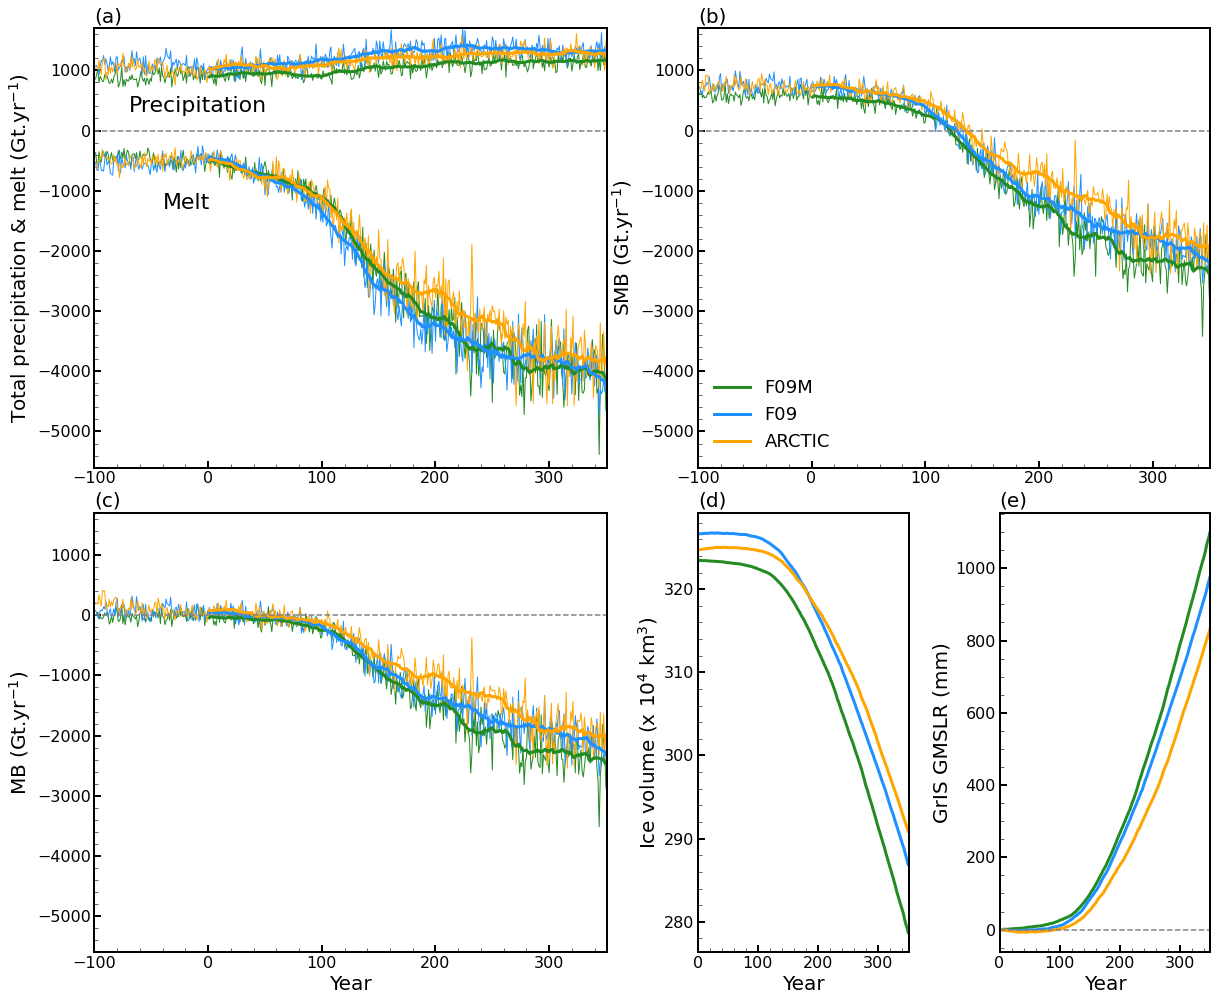

In [17]:
fig = plt.figure(figsize = (20,17))
gs=GridSpec(4,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- Precip & Melt --------------------------------------------
ax0 = plt.subplot(gs[0:2,0:2])

ax0.plot(np.arange(-99,1), BG7_int_prec[49:149], color = 'forestgreen', linewidth = 1, label='Muntjewerf f09')
ax0.plot(np.arange(1,351), f09_int_1pctCO2_4xext_prec, color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(-99,1), f09_nohacks_int_piControl_prec[-100:], color = 'dodgerblue', linewidth = 1, label='f09')
ax0.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_prec, color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(-99,1), ARCTIC_int_piControl_prec[-100:], color = 'orange', linewidth = 1)
ax0.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_prec, color = 'orange', linewidth = 1)

ax0.plot(np.arange(1,351), f09_int_1pctCO2_4xext_prec_rm, color = 'forestgreen', linewidth = 3)
ax0.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_prec_rm, color = 'dodgerblue', linewidth = 3)
ax0.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_prec_rm, color = 'orange', linewidth = 3)

ax0.plot(np.arange(-99,1), -BG7_int_melt[49:149], color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(1,351), -f09_int_1pctCO2_4xext_melt, color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(-99,1), -f09_nohacks_int_piControl_melt[-100:], color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(1,351), -f09_nohacks_int_1pctCO2_4xext_melt, color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(-99,1), -ARCTIC_int_piControl_melt[-100:], color = 'orange', linewidth = 1)
ax0.plot(np.arange(1,351), -ARCTIC_int_1pctCO2_4xext_melt, color = 'orange', linewidth = 1)

ax0.plot(np.arange(1,351), -f09_int_1pctCO2_4xext_melt_rm, color = 'forestgreen', linewidth = 3)
ax0.plot(np.arange(1,351), -f09_nohacks_int_1pctCO2_4xext_melt_rm, color = 'dodgerblue', linewidth = 3)
ax0.plot(np.arange(1,351), -ARCTIC_int_1pctCO2_4xext_melt_rm, color = 'orange', linewidth = 3)
plt.axhline(y=0., color='gray', linestyle='--')

plt.text(-70, 300, 'Precipitation', fontsize=22)
plt.text(-40, -1300, 'Melt', fontsize=22)
plt.title('(a)', loc='left', fontsize=20)

ax0.set_xlim([-100, 351])
ax0.set_ylim([-5600, 1700])
ax0.set_ylabel('Total precipitation & melt (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.tick_params(which='major', length=7, width=2, direction='in')
ax0.tick_params(which='minor', length=4, direction='in')
ax0.tick_params(labelsize=size_tick)

#-------------------------------------------- SMB --------------------------------------------
ax1 = plt.subplot(gs[0:2,2:4])

ax1.plot(np.arange(-99,1), BG7_int_total_smb_flux[49:149], color = 'forestgreen', linewidth = 1)
ax1.plot(np.arange(1,351), f09_int_1pctCO2_4xext_total_smb_flux, color = 'forestgreen', linewidth = 1)
ax1.plot(np.arange(-99,1), f09_nohacks_int_piControl_total_smb_flux[-100:], color = 'dodgerblue', linewidth = 1)
ax1.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_total_smb_flux, color = 'dodgerblue', linewidth = 1)
ax1.plot(np.arange(-99,-79), ARCTIC_int_piControl_p3_total_smb_flux[-20:], color = 'orange', linewidth = 1)
ax1.plot(np.arange(-79,1), ARCTIC_int_piControl_p4_total_smb_flux, color = 'orange', linewidth = 1)
ax1.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_total_smb_flux, color = 'orange', linewidth = 1)

f09_int_1pctCO2_4xext_total_smb_flux_rm = f09_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_total_smb_flux_rm = f09_nohacks_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_total_smb_flux_rm = ARCTIC_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), f09_int_1pctCO2_4xext_total_smb_flux_rm, color = 'forestgreen', linewidth = 3, label='F09M')
ax1.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_total_smb_flux_rm, color = 'dodgerblue', linewidth = 3, label='F09')
ax1.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_total_smb_flux_rm, color = 'orange', linewidth = 3, label='ARCTIC')
plt.axhline(y=0., color='gray', linestyle='--')

plt.title('(b)', loc='left', fontsize='20')

ax1.set_xlim([-100, 351])
ax1.set_ylim([-5600, 1700])
ax1.set_ylabel('SMB (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc = 'lower left', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- MB --------------------------------------------
ax2 = plt.subplot(gs[2:4,0:2])

ax2.plot(np.arange(-99,1), BG7_int_mb[49:149], color = 'forestgreen', linewidth = 1, label='Muntjewerf f09')
ax2.plot(np.arange(1,351), f09_int_1pctCO2_4xext_mb, color = 'forestgreen', linewidth = 1)
ax2.plot(np.arange(-99,1), f09_nohacks_int_piControl_mb[-100:], color = 'dodgerblue', linewidth = 1, label='f09')
ax2.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_mb, color = 'dodgerblue', linewidth = 1)
ax2.plot(np.arange(-99,-79), ARCTIC_int_piControl_p3_mb[-20:], color = 'orange', linewidth = 1, label='ARCTIC')
ax2.plot(np.arange(-79,1), ARCTIC_int_piControl_p4_mb, color = 'orange', linewidth = 1)
ax2.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_mb, color = 'orange', linewidth = 1)

f09_int_1pctCO2_4xext_mb_rm = f09_int_1pctCO2_4xext_mb.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_mb_rm = f09_nohacks_int_1pctCO2_4xext_mb.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_mb_rm = ARCTIC_int_1pctCO2_4xext_mb.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), f09_int_1pctCO2_4xext_mb_rm, color = 'forestgreen', linewidth = 3)
ax2.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_mb_rm, color = 'dodgerblue', linewidth = 3)
ax2.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_mb_rm, color = 'orange', linewidth = 3)
plt.axhline(y=0., color='gray', linestyle='--')

plt.title('(c)', loc='left', fontsize='20')

ax2.set_xlim([-100, 351])
ax2.set_ylim([-5600, 1700])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('MB (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)

#-------------------------------------------- ivol --------------------------------------------
ax3 = plt.subplot(gs[2:4,2:3])

ax3.plot(np.arange(-99,1), BG7_int_ivol[49:149], color = 'forestgreen', linewidth=3)
ax3.plot(np.arange(1,351), f09_int_1pctCO2_4xext_ivol, color='forestgreen', linewidth=3)
ax3.plot(np.arange(-99,1), f09_nohacks_int_piControl_ivol[-100:], color = 'dodgerblue', linewidth=3)
ax3.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_ivol, color='dodgerblue', linewidth=3)
ax3.plot(np.arange(-99,-79), ARCTIC_int_piControl_p3_ivol[-20:], color = 'orange', linewidth=3)
ax3.plot(np.arange(-79,1), ARCTIC_int_piControl_p4_ivol, color = 'orange', linewidth=3)
ax3.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_ivol, color='orange', linewidth=3)

plt.title('(d)', loc='left', fontsize='20')

ax3.set_xlim([0, 351])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('Ice volume (x $\mathregular{10^{4}}$ $\mathregular{km^{3}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)

#-------------------------------------------- GMSLR --------------------------------------------
ax4 = plt.subplot(gs[2:4,3:4])

ax4.plot(np.arange(1,351), f09_int_1pctCO2_4xext_slr, color='forestgreen', linewidth=3)
ax4.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_slr, color='dodgerblue', linewidth=3)
ax4.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_slr, color='orange', linewidth=3)
plt.axhline(y=0., color='gray', linestyle='--')

plt.title('(e)', loc='left', fontsize='20')

ax4.set_xlim([0, 351])
ax4.set_xlabel('Year', fontsize=size_label)
ax4.set_ylabel('GrIS GMSLR (mm)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)


plt.subplots_adjust(wspace=0.43, hspace=0.23)
plt.savefig(home_dir+'dynamic_GrIS/github/plot/tseries_prec_melt_SMB_MB_ivol_SLR.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

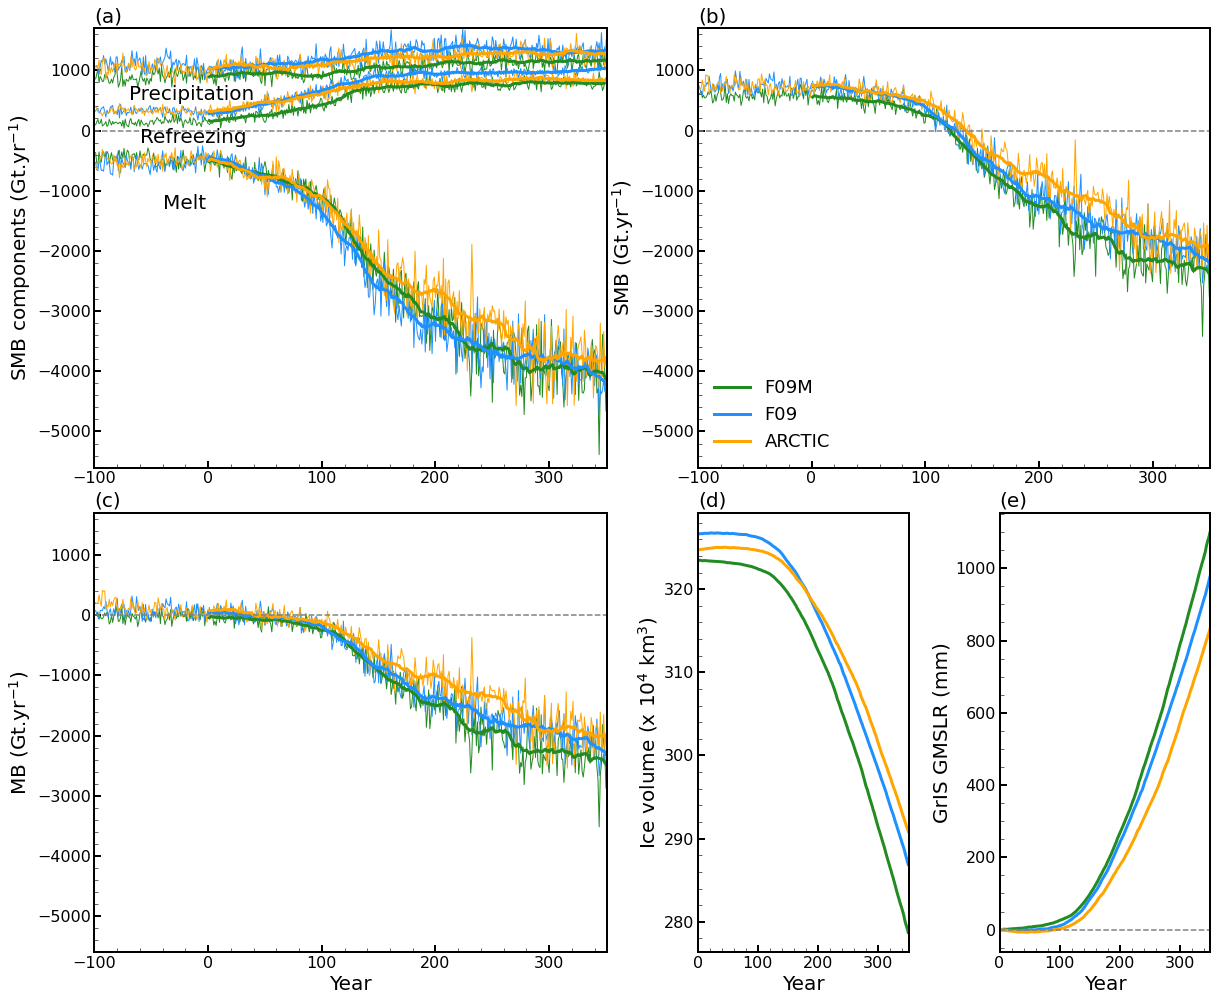

In [15]:
# Add refreezing
fig = plt.figure(figsize = (20,17))
gs=GridSpec(4,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- Precip & Melt --------------------------------------------
ax0 = plt.subplot(gs[0:2,0:2])

# precip
ax0.plot(np.arange(-99,1), BG7_int_prec[49:149], color = 'forestgreen', linewidth = 1, label='Muntjewerf f09')
ax0.plot(np.arange(1,351), f09_int_1pctCO2_4xext_prec, color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(-99,1), f09_nohacks_int_piControl_prec[-100:], color = 'dodgerblue', linewidth = 1, label='f09')
ax0.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_prec, color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(-99,1), ARCTIC_int_piControl_prec[-100:], color = 'orange', linewidth = 1)
ax0.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_prec, color = 'orange', linewidth = 1)

ax0.plot(np.arange(1,351), f09_int_1pctCO2_4xext_prec_rm, color = 'forestgreen', linewidth = 3)
ax0.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_prec_rm, color = 'dodgerblue', linewidth = 3)
ax0.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_prec_rm, color = 'orange', linewidth = 3)

# melt
ax0.plot(np.arange(-99,1), -BG7_int_melt[49:149], color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(1,351), -f09_int_1pctCO2_4xext_melt, color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(-99,1), -f09_nohacks_int_piControl_melt[-100:], color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(1,351), -f09_nohacks_int_1pctCO2_4xext_melt, color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(-99,1), -ARCTIC_int_piControl_melt[-100:], color = 'orange', linewidth = 1)
ax0.plot(np.arange(1,351), -ARCTIC_int_1pctCO2_4xext_melt, color = 'orange', linewidth = 1)

ax0.plot(np.arange(1,351), -f09_int_1pctCO2_4xext_melt_rm, color = 'forestgreen', linewidth = 3)
ax0.plot(np.arange(1,351), -f09_nohacks_int_1pctCO2_4xext_melt_rm, color = 'dodgerblue', linewidth = 3)
ax0.plot(np.arange(1,351), -ARCTIC_int_1pctCO2_4xext_melt_rm, color = 'orange', linewidth = 3)

# refreezing
ax0.plot(np.arange(-99,1), BG7_int_refrz[49:149], color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(1,351), f09_int_1pctCO2_4xext_refrz, color = 'forestgreen', linewidth = 1)
ax0.plot(np.arange(-99,1), f09_nohacks_int_piControl_refrz[-100:], color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_refrz, color = 'dodgerblue', linewidth = 1)
ax0.plot(np.arange(-99,1), ARCTIC_int_piControl_refrz[-100:], color = 'orange', linewidth = 1)
ax0.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_refrz, color = 'orange', linewidth = 1)

ax0.plot(np.arange(1,351), f09_int_1pctCO2_4xext_refrz_rm, color = 'forestgreen', linewidth = 3)
ax0.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_refrz_rm, color = 'dodgerblue', linewidth = 3)
ax0.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_refrz_rm, color = 'orange', linewidth = 3)
plt.axhline(y=0., color='gray', linestyle='--')

plt.text(-70, 500, 'Precipitation', fontsize=20)
plt.text(-60, -200, 'Refreezing', fontsize=20)
plt.text(-40, -1300, 'Melt', fontsize=20)
plt.title('(a)', loc='left', fontsize=20)

ax0.set_xlim([-100, 351])
ax0.set_ylim([-5600, 1700])
ax0.set_ylabel('SMB components (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.tick_params(which='major', length=7, width=2, direction='in')
ax0.tick_params(which='minor', length=4, direction='in')
ax0.tick_params(labelsize=size_tick)

#-------------------------------------------- SMB --------------------------------------------
ax1 = plt.subplot(gs[0:2,2:4])

ax1.plot(np.arange(-99,1), BG7_int_total_smb_flux[49:149], color = 'forestgreen', linewidth = 1)
ax1.plot(np.arange(1,351), f09_int_1pctCO2_4xext_total_smb_flux, color = 'forestgreen', linewidth = 1)
ax1.plot(np.arange(-99,1), f09_nohacks_int_piControl_total_smb_flux[-100:], color = 'dodgerblue', linewidth = 1)
ax1.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_total_smb_flux, color = 'dodgerblue', linewidth = 1)
ax1.plot(np.arange(-99,-79), ARCTIC_int_piControl_p3_total_smb_flux[-20:], color = 'orange', linewidth = 1)
ax1.plot(np.arange(-79,1), ARCTIC_int_piControl_p4_total_smb_flux, color = 'orange', linewidth = 1)
ax1.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_total_smb_flux, color = 'orange', linewidth = 1)

f09_int_1pctCO2_4xext_total_smb_flux_rm = f09_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_total_smb_flux_rm = f09_nohacks_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_total_smb_flux_rm = ARCTIC_int_1pctCO2_4xext_total_smb_flux.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), f09_int_1pctCO2_4xext_total_smb_flux_rm, color = 'forestgreen', linewidth = 3, label='F09M')
ax1.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_total_smb_flux_rm, color = 'dodgerblue', linewidth = 3, label='F09')
ax1.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_total_smb_flux_rm, color = 'orange', linewidth = 3, label='ARCTIC')
plt.axhline(y=0., color='gray', linestyle='--')

plt.title('(b)', loc='left', fontsize='20')

ax1.set_xlim([-100, 351])
ax1.set_ylim([-5600, 1700])
ax1.set_ylabel('SMB (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc = 'lower left', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- MB --------------------------------------------
ax2 = plt.subplot(gs[2:4,0:2])

ax2.plot(np.arange(-99,1), BG7_int_mb[49:149], color = 'forestgreen', linewidth = 1, label='Muntjewerf f09')
ax2.plot(np.arange(1,351), f09_int_1pctCO2_4xext_mb, color = 'forestgreen', linewidth = 1)
ax2.plot(np.arange(-99,1), f09_nohacks_int_piControl_mb[-100:], color = 'dodgerblue', linewidth = 1, label='f09')
ax2.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_mb, color = 'dodgerblue', linewidth = 1)
ax2.plot(np.arange(-99,-79), ARCTIC_int_piControl_p3_mb[-20:], color = 'orange', linewidth = 1, label='ARCTIC')
ax2.plot(np.arange(-79,1), ARCTIC_int_piControl_p4_mb, color = 'orange', linewidth = 1)
ax2.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_mb, color = 'orange', linewidth = 1)

f09_int_1pctCO2_4xext_mb_rm = f09_int_1pctCO2_4xext_mb.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_int_1pctCO2_4xext_mb_rm = f09_nohacks_int_1pctCO2_4xext_mb.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_int_1pctCO2_4xext_mb_rm = ARCTIC_int_1pctCO2_4xext_mb.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), f09_int_1pctCO2_4xext_mb_rm, color = 'forestgreen', linewidth = 3)
ax2.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_mb_rm, color = 'dodgerblue', linewidth = 3)
ax2.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_mb_rm, color = 'orange', linewidth = 3)
plt.axhline(y=0., color='gray', linestyle='--')

plt.title('(c)', loc='left', fontsize='20')

ax2.set_xlim([-100, 351])
ax2.set_ylim([-5600, 1700])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('MB (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)

#-------------------------------------------- ivol --------------------------------------------
ax3 = plt.subplot(gs[2:4,2:3])

ax3.plot(np.arange(-99,1), BG7_int_ivol[49:149], color = 'forestgreen', linewidth=3)
ax3.plot(np.arange(1,351), f09_int_1pctCO2_4xext_ivol, color='forestgreen', linewidth=3)
ax3.plot(np.arange(-99,1), f09_nohacks_int_piControl_ivol[-100:], color = 'dodgerblue', linewidth=3)
ax3.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_ivol, color='dodgerblue', linewidth=3)
ax3.plot(np.arange(-99,-79), ARCTIC_int_piControl_p3_ivol[-20:], color = 'orange', linewidth=3)
ax3.plot(np.arange(-79,1), ARCTIC_int_piControl_p4_ivol, color = 'orange', linewidth=3)
ax3.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_ivol, color='orange', linewidth=3)

plt.title('(d)', loc='left', fontsize='20')

ax3.set_xlim([0, 351])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('Ice volume (x $\mathregular{10^{4}}$ $\mathregular{km^{3}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)

#-------------------------------------------- GMSLR --------------------------------------------
ax4 = plt.subplot(gs[2:4,3:4])

ax4.plot(np.arange(1,351), f09_int_1pctCO2_4xext_slr, color='forestgreen', linewidth=3)
ax4.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_slr, color='dodgerblue', linewidth=3)
ax4.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_slr, color='orange', linewidth=3)
plt.axhline(y=0., color='gray', linestyle='--')

plt.title('(e)', loc='left', fontsize='20')

ax4.set_xlim([0, 351])
ax4.set_xlabel('Year', fontsize=size_label)
ax4.set_ylabel('GrIS GMSLR (mm)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)


plt.subplots_adjust(wspace=0.43, hspace=0.23)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_prec_melt_refrz_SMB_MB_ivol_SLR.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## Values

### MB components

In [18]:
## F09M
print('F09M')
print('')

print('Year -19-0')
print('F09M(P0), MB: ', BG7_int_mb[129:149].mean().round(2).values)
print('F09M(P0), SMB: ', BG7_int_total_smb_flux[129:149].mean().round(2).values)
print('F09M(P0), ID: ', BG7_int_total_calving_flux[129:149].mean().round(2).values)
print('F09M(P0), BMB: ', BG7_int_total_bmb_flux[129:149].mean().round(2).values)
print('')

print('Year 131-150')
print('F09M(P1), MB: ', f09_int_1pctCO2_4xext_mb[130:150].mean().round(2).values)
print('F09M(P1), SMB: ', f09_int_1pctCO2_4xext_total_smb_flux[130:150].mean().round(2).values)
print('F09M(P1), ID: ', f09_int_1pctCO2_4xext_total_calving_flux[130:150].mean().round(2).values)
print('F09M(P1), BMB: ', f09_int_1pctCO2_4xext_total_bmb_flux[130:150].mean().round(2).values)
print('')

print('Year 231-250')
print('F09M(P2), MB: ', f09_int_1pctCO2_4xext_mb[230:250].mean().round(2).values)
print('F09M(P2), SMB: ', f09_int_1pctCO2_4xext_total_smb_flux[230:250].mean().round(2).values)
print('F09M(P2), ID: ', f09_int_1pctCO2_4xext_total_calving_flux[230:250].mean().round(2).values)
print('F09M(P2), BMB: ', f09_int_1pctCO2_4xext_total_bmb_flux[230:250].mean().round(2).values)
print('')

print('Year 331-350')
print('F09M(P3), MB: ', f09_int_1pctCO2_4xext_mb[330:350].mean().round(2).values)
print('F09M(P3), SMB: ', f09_int_1pctCO2_4xext_total_smb_flux[330:350].mean().round(2).values)
print('F09M(P3), ID: ', f09_int_1pctCO2_4xext_total_calving_flux[330:350].mean().round(2).values)
print('F09M(P3), BMB: ', f09_int_1pctCO2_4xext_total_bmb_flux[330:350].mean().round(2).values)

F09M

Year -19-0
F09M(P0), MB:  19.07
F09M(P0), SMB:  615.99
F09M(P0), ID:  -572.98
F09M(P0), BMB:  -23.94

Year 131-150
F09M(P1), MB:  -775.76
F09M(P1), SMB:  -380.23
F09M(P1), ID:  -375.96
F09M(P1), BMB:  -19.57

Year 231-250
F09M(P2), MB:  -1973.79
F09M(P2), SMB:  -1797.29
F09M(P2), ID:  -160.64
F09M(P2), BMB:  -15.86

Year 331-350
F09M(P3), MB:  -2375.75
F09M(P3), SMB:  -2283.99
F09M(P3), ID:  -77.9
F09M(P3), BMB:  -13.86


In [19]:
## F09
print('F09')
print('')

print('Year -19-0')
print('F09(P0), MB: ', f09_nohacks_int_piControl_mb[-20:].mean().round(2).values)
print('F09(P0), SMB: ', f09_nohacks_int_piControl_total_smb_flux[-20:].mean().round(2).values)
print('F09(P0), ID: ', f09_nohacks_int_piControl_total_calving_flux[-20:].mean().round(2).values)
print('F09(P0), BMB: ', f09_nohacks_int_piControl_total_bmb_flux[-20:].mean().round(2).values)
print('')

print('Year 131-150')
print('F09(P1), MB: ', f09_nohacks_int_1pctCO2_4xext_mb[130:150].mean().round(2).values)
print('F09(P1), SMB: ', f09_nohacks_int_1pctCO2_4xext_total_smb_flux[130:150].mean().round(2).values)
print('F09(P1), ID: ', f09_nohacks_int_1pctCO2_4xext_total_calving_flux[130:150].mean().round(2).values)
print('F09(P1), BMB: ', f09_nohacks_int_1pctCO2_4xext_total_bmb_flux[130:150].mean().round(2).values)
print('')

print('Year 231-250')
print('F09(P2), MB: ', f09_nohacks_int_1pctCO2_4xext_mb[230:250].mean().round(2).values)
print('F09(P2), SMB: ', f09_nohacks_int_1pctCO2_4xext_total_smb_flux[230:250].mean().round(2).values)
print('F09(P2), ID: ', f09_nohacks_int_1pctCO2_4xext_total_calving_flux[230:250].mean().round(2).values)
print('F09(P2), BMB: ', f09_nohacks_int_1pctCO2_4xext_total_bmb_flux[230:250].mean().round(2).values)
print('')

print('Year 331-350')
print('F09(P3), MB: ', f09_nohacks_int_1pctCO2_4xext_mb[330:350].mean().round(2).values)
print('F09(P3), SMB: ', f09_nohacks_int_1pctCO2_4xext_total_smb_flux[330:350].mean().round(2).values)
print('F09(P3), ID: ', f09_nohacks_int_1pctCO2_4xext_total_calving_flux[330:350].mean().round(2).values)
print('F09(P3), BMB: ', f09_nohacks_int_1pctCO2_4xext_total_bmb_flux[330:350].mean().round(2).values)

F09

Year -19-0
F09(P0), MB:  41.19
F09(P0), SMB:  722.5
F09(P0), ID:  -654.41
F09(P0), BMB:  -26.9

Year 131-150
F09(P1), MB:  -760.63
F09(P1), SMB:  -318.59
F09(P1), ID:  -419.81
F09(P1), BMB:  -22.23

Year 231-250
F09(P2), MB:  -1668.82
F09(P2), SMB:  -1463.14
F09(P2), ID:  -187.21
F09(P2), BMB:  -18.47

Year 331-350
F09(P3), MB:  -2194.57
F09(P3), SMB:  -2097.44
F09(P3), ID:  -80.67
F09(P3), BMB:  -16.46


In [20]:
## F09M
print('ARCTIC')
print('')

print('Year -19-0')
print('ARCTIC(P0), MB: ', ARCTIC_int_piControl_p4_mb[-20:].mean().round(2).values)
print('ARCTIC(P0), SMB: ', ARCTIC_int_piControl_p4_total_smb_flux[-20:].mean().round(2).values)
print('ARCTIC(P0), ID: ', ARCTIC_int_piControl_p4_total_calving_flux[-20:].mean().round(2).values)
print('ARCTIC(P0), BMB: ', ARCTIC_int_piControl_p4_total_bmb_flux[-20:].mean().round(2).values)
print('')

print('Year 131-150')
print('ARCTIC(P1), MB: ', ARCTIC_int_1pctCO2_4xext_mb[130:150].mean().round(2).values)
print('ARCTIC(P1), SMB: ', ARCTIC_int_1pctCO2_4xext_total_smb_flux[130:150].mean().round(2).values)
print('ARCTIC(P1), ID: ', ARCTIC_int_1pctCO2_4xext_total_calving_flux[130:150].mean().round(2).values)
print('ARCTIC(P1), BMB: ', ARCTIC_int_1pctCO2_4xext_total_bmb_flux[130:150].mean().round(2).values)
print('')

print('Year 231-250')
print('ARCTIC(P2), MB: ', ARCTIC_int_1pctCO2_4xext_mb[230:250].mean().round(2).values)
print('ARCTIC(P2), SMB: ', ARCTIC_int_1pctCO2_4xext_total_smb_flux[230:250].mean().round(2).values)
print('ARCTIC(P2), ID: ', ARCTIC_int_1pctCO2_4xext_total_calving_flux[230:250].mean().round(2).values)
print('ARCTIC(P2), BMB: ', ARCTIC_int_1pctCO2_4xext_total_bmb_flux[230:250].mean().round(2).values)
print('')

print('Year 331-350')
print('ARCTIC(P3), MB: ', ARCTIC_int_1pctCO2_4xext_mb[330:350].mean().round(2).values)
print('ARCTIC(P3), SMB: ', ARCTIC_int_1pctCO2_4xext_total_smb_flux[330:350].mean().round(2).values)
print('ARCTIC(P3), ID: ', ARCTIC_int_1pctCO2_4xext_total_calving_flux[330:350].mean().round(2).values)
print('ARCTIC(P3), BMB: ', ARCTIC_int_1pctCO2_4xext_total_bmb_flux[330:350].mean().round(2).values)

ARCTIC

Year -19-0
ARCTIC(P0), MB:  23.35
ARCTIC(P0), SMB:  684.82
ARCTIC(P0), ID:  -636.27
ARCTIC(P0), BMB:  -25.2

Year 131-150
ARCTIC(P1), MB:  -541.77
ARCTIC(P1), SMB:  -71.66
ARCTIC(P1), ID:  -448.39
ARCTIC(P1), BMB:  -21.72

Year 231-250
ARCTIC(P2), MB:  -1285.41
ARCTIC(P2), SMB:  -1081.3
ARCTIC(P2), ID:  -186.59
ARCTIC(P2), BMB:  -17.52

Year 331-350
ARCTIC(P3), MB:  -2001.3
ARCTIC(P3), SMB:  -1908.83
ARCTIC(P3), ID:  -76.76
ARCTIC(P3), BMB:  -15.71


In [21]:
## Annual mass loss (mm/yr)
# Method 1: using mass balance time series
rho_ice = 910. #rhoi
rho_seawater = 1028. #rhoo
f09_ocn_area = np.sum(f09_area) - (f09_area * f09_land_frac).sum(dim=['lat','lon']) #m2
ARCTIC_ocn_area = np.sum(ARCTIC_area) - (ARCTIC_area[0,:] * ARCTIC_land_frac).sum(dim='lndgrid') #m2

# F09M
print('F09M(P1), MB(aml): ', -(f09_int_1pctCO2_4xext_mb[130:150].mean() * 1e12 / (rho_seawater * f09_ocn_area) * 1e3).round(2).values) #mm sea water
print('F09M(P2), MB(aml): ', -(f09_int_1pctCO2_4xext_mb[230:250].mean() * 1e12 / (rho_seawater * f09_ocn_area) * 1e3).round(2).values)
print('F09M(P3), MB(aml): ', -(f09_int_1pctCO2_4xext_mb[330:350].mean() * 1e12 / (rho_seawater * f09_ocn_area) * 1e3).round(2).values)
print('')

# F09
print('F09(P1), MB(aml): ', -(f09_nohacks_int_1pctCO2_4xext_mb[130:150].mean() * 1e12 / (rho_seawater * f09_ocn_area) * 1e3).round(2).values)
print('F09(P2), MB(aml): ', -(f09_nohacks_int_1pctCO2_4xext_mb[230:250].mean() * 1e12 / (rho_seawater * f09_ocn_area) * 1e3).round(2).values)
print('F09(P3), MB(aml): ', -(f09_nohacks_int_1pctCO2_4xext_mb[330:350].mean() * 1e12 / (rho_seawater * f09_ocn_area) * 1e3).round(2).values)
print('')

# ARCTIC
print('ARCTIC(P1), MB(aml): ', -(ARCTIC_int_1pctCO2_4xext_mb[130:150].mean() * 1e12 / (rho_seawater * ARCTIC_ocn_area) * 1e3).round(2).values) #mm sea water
print('ARCTIC(P2), MB(aml): ', -(ARCTIC_int_1pctCO2_4xext_mb[230:250].mean() * 1e12 / (rho_seawater * ARCTIC_ocn_area) * 1e3).round(2).values)
print('ARCTIC(P3), MB(aml): ', -(ARCTIC_int_1pctCO2_4xext_mb[330:350].mean() * 1e12 / (rho_seawater * ARCTIC_ocn_area) * 1e3).round(2).values)
print('')

F09M(P1), MB(aml):  2.09
F09M(P2), MB(aml):  5.32
F09M(P3), MB(aml):  6.41

F09(P1), MB(aml):  2.05
F09(P2), MB(aml):  4.5
F09(P3), MB(aml):  5.92

ARCTIC(P1), MB(aml):  1.46
ARCTIC(P2), MB(aml):  3.47
ARCTIC(P3), MB(aml):  5.4



In [22]:
## Annual mass loss (mm/yr)
# Method 2: using ice volume time series (get similar results)

ARCTIC_ocn_area = np.sum(ARCTIC_area) - (ARCTIC_area[0,:] * ARCTIC_land_frac).sum(dim='lndgrid') #m2

# F09M
print('F09M(P0), MB(aml): ', -((BG7_int_ivol[148]- BG7_int_ivol[128]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values) #mm sea water
print('F09M(P1), MB(aml): ', -((f09_int_1pctCO2_4xext_ivol[149]- f09_int_1pctCO2_4xext_ivol[129]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values) #mm sea water
print('F09M(P2), MB(aml): ', -((f09_int_1pctCO2_4xext_ivol[249]- f09_int_1pctCO2_4xext_ivol[229]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values)
print('F09M(P3), MB(aml): ', -((f09_int_1pctCO2_4xext_ivol[349]- f09_int_1pctCO2_4xext_ivol[329]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values)
print('')

# F09
print('F09(P0), MB(aml): ', -((f09_nohacks_int_piControl_ivol[-1]-f09_nohacks_int_piControl_ivol[-21]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values) #mm sea water
print('F09(P1), MB(aml): ', -((f09_nohacks_int_1pctCO2_4xext_ivol[149]- f09_nohacks_int_1pctCO2_4xext_ivol[129]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values) #mm sea water
print('F09(P2), MB(aml): ', -((f09_nohacks_int_1pctCO2_4xext_ivol[249]- f09_nohacks_int_1pctCO2_4xext_ivol[229]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values)
print('F09(P3), MB(aml): ', -((f09_nohacks_int_1pctCO2_4xext_ivol[349]- f09_nohacks_int_1pctCO2_4xext_ivol[329]) * 1e13 * rho_ice / (rho_seawater * f09_ocn_area * 20) * 1e3).round(2).values)
print('')

# ARCTIC
print('ARCTIC(P0), MB(aml): ', -((ARCTIC_int_piControl_p4_ivol[-1]- ARCTIC_int_piControl_p4_ivol[-21]) * 1e13 * rho_ice / (rho_seawater * ARCTIC_ocn_area * 20) * 1e3).round(2).values) #mm sea water
print('ARCTIC(P1), MB(aml): ', -((ARCTIC_int_1pctCO2_4xext_ivol[149]- ARCTIC_int_1pctCO2_4xext_ivol[129]) * 1e13 * rho_ice / (rho_seawater * ARCTIC_ocn_area * 20) * 1e3).round(2).values) #mm sea water
print('ARCTIC(P2), MB(aml): ', -((ARCTIC_int_1pctCO2_4xext_ivol[249]- ARCTIC_int_1pctCO2_4xext_ivol[229]) * 1e13 * rho_ice / (rho_seawater * ARCTIC_ocn_area * 20) * 1e3).round(2).values)
print('ARCTIC(P3), MB(aml): ', -((ARCTIC_int_1pctCO2_4xext_ivol[349]- ARCTIC_int_1pctCO2_4xext_ivol[329]) * 1e13 * rho_ice / (rho_seawater * ARCTIC_ocn_area * 20) * 1e3).round(2).values)
print('')

F09M(P0), MB(aml):  -0.04
F09M(P1), MB(aml):  2.08
F09M(P2), MB(aml):  5.28
F09M(P3), MB(aml):  6.36

F09(P0), MB(aml):  -0.1
F09(P1), MB(aml):  2.06
F09(P2), MB(aml):  4.49
F09(P3), MB(aml):  5.93

ARCTIC(P0), MB(aml):  -0.05
ARCTIC(P1), MB(aml):  1.48
ARCTIC(P2), MB(aml):  3.5
ARCTIC(P3), MB(aml):  5.4



### Ice sheet area, volume

In [23]:
## GrIS area
# Method 1: use 'iarea' from the CISM

# F09M
print('F09M(P0), iarea: ', (BG7_int_iarea[129:149].mean()).round(2).values) #Mkm2
print('F09M(P1), iarea: ', (f09_int_1pctCO2_4xext_iarea[130:150].mean()).round(2).values) #Mkm2
print('F09M(P2), iarea: ', (f09_int_1pctCO2_4xext_iarea[230:250].mean()).round(2).values) #Mkm2
print('F09M(P3), iarea: ', (f09_int_1pctCO2_4xext_iarea[330:350].mean()).round(2).values) #Mkm2
print('')

# F09M
print('F09(P0), iarea: ', (f09_nohacks_int_piControl_iarea[-20:].mean()).round(2).values) #Mkm2
print('F09(P1), iarea: ', (f09_nohacks_int_1pctCO2_4xext_iarea[130:150].mean()).round(2).values) #Mkm2
print('F09(P2), iarea: ', (f09_nohacks_int_1pctCO2_4xext_iarea[230:250].mean()).round(2).values) #Mkm2
print('F09(P3), iarea: ', (f09_nohacks_int_1pctCO2_4xext_iarea[330:350].mean()).round(2).values) #Mkm2
print('')

# ARCTIC
print('ARCTIC(P0), iarea: ', (ARCTIC_int_piControl_p4_iarea[-20:].mean()).round(2).values) #Mkm2
print('ARCTIC(P1), iarea: ', (ARCTIC_int_1pctCO2_4xext_iarea[130:150].mean()).round(2).values) #Mkm2
print('ARCTIC(P2), iarea: ', (ARCTIC_int_1pctCO2_4xext_iarea[230:250].mean()).round(2).values) #Mkm2
print('ARCTIC(P3), iarea: ', (ARCTIC_int_1pctCO2_4xext_iarea[330:350].mean()).round(2).values) #Mkm2
print('')

F09M(P0), iarea:  1.97
F09M(P1), iarea:  1.92
F09M(P2), iarea:  1.77
F09M(P3), iarea:  1.6

F09(P0), iarea:  2.0
F09(P1), iarea:  1.96
F09(P2), iarea:  1.8
F09(P3), iarea:  1.64

ARCTIC(P0), iarea:  2.02
ARCTIC(P1), iarea:  1.99
ARCTIC(P2), iarea:  1.83
ARCTIC(P3), iarea:  1.66



In [24]:
## GrIS volume

# F09M
print('F09M(P0), ivol: ', (BG7_int_ivol[129:149].mean()/100).round(2).values) #10^6 km3
print('F09M(P1), ivol: ', (f09_int_1pctCO2_4xext_ivol[130:150].mean()/100).round(2).values) #10^6 km3
print('F09M(P2), ivol: ', (f09_int_1pctCO2_4xext_ivol[230:250].mean()/100).round(2).values) 
print('F09M(P3), ivol: ', (f09_int_1pctCO2_4xext_ivol[330:350].mean()/100).round(2).values) 
print('')

# F09M
print('F09(P0), ivol: ', (f09_nohacks_int_piControl_ivol[-20:].mean()/100).round(2).values) 
print('F09(P1), ivol: ', (f09_nohacks_int_1pctCO2_4xext_ivol[130:150].mean()/100).round(2).values) 
print('F09(P2), ivol: ', (f09_nohacks_int_1pctCO2_4xext_ivol[230:250].mean()/100).round(2).values) 
print('F09(P3), ivol: ', (f09_nohacks_int_1pctCO2_4xext_ivol[330:350].mean()/100).round(2).values) 
print('')

# ARCTIC
print('ARCTIC(P0), ivol: ', (ARCTIC_int_piControl_p4_ivol[-20:].mean()/100).round(2).values) 
print('ARCTIC(P1), ivol: ', (ARCTIC_int_1pctCO2_4xext_ivol[130:150].mean()/100).round(2).values) 
print('ARCTIC(P2), ivol: ', (ARCTIC_int_1pctCO2_4xext_ivol[230:250].mean()/100).round(2).values) 
print('ARCTIC(P3), ivol: ', (ARCTIC_int_1pctCO2_4xext_ivol[330:350].mean()/100).round(2).values) 
print('')

F09M(P0), ivol:  3.23
F09M(P1), ivol:  3.2
F09M(P2), ivol:  3.05
F09M(P3), ivol:  2.81

F09(P0), ivol:  3.27
F09(P1), ivol:  3.24
F09(P2), ivol:  3.1
F09(P3), ivol:  2.89

ARCTIC(P0), ivol:  3.25
ARCTIC(P1), ivol:  3.23
ARCTIC(P2), ivol:  3.12
ARCTIC(P3), ivol:  2.93



### Sea level rise contribution

##### F09M

In [26]:
# Use year zero in F09M 1pctCO2 (same to year zero in F09M piControl)
rho_ice = 910. #rhoi
rho_seawater = 1028. #rhoo

f09_ocn_area = np.sum(f09_area) - (f09_area * f09_land_frac).sum(dim=['lat','lon']) #m2

f09_slr_cum_yr0 = -(BG7_int_ivol[148] - BG7_int_ivol[128]) * 1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_int_1pctCO2_ivol_all = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.ivol.0001-0161.nc')['ivol'][:]
f09_int_piControl_ivol_end = f09_int_1pctCO2_ivol_all[0] # This is the same to BG7_int_ivol[148], representing year 150 of BG7

f09_1pctCO2_ivol_yr140 = f09_int_1pctCO2_ivol[139] * 1e13
f09_slr_cum_yr140 = -(f09_1pctCO2_ivol_yr140 - f09_int_piControl_ivol_end) * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_4xext_ivol_yr150 = f09_int_4xext_ivol[9] * 1e13
f09_slr_cum_yr150 = -(f09_4xext_ivol_yr150 - f09_int_piControl_ivol_end) * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_4xext_ivol_yr250 = f09_int_4xext_ivol[109] * 1e13
f09_slr_cum_yr250 = -(f09_4xext_ivol_yr250 - f09_int_piControl_ivol_end) * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_4xext_ivol_yr350 = f09_int_4xext_ivol[-1] * 1e13
f09_slr_cum_yr350 = -(f09_4xext_ivol_yr350 - f09_int_piControl_ivol_end) * (rho_ice/rho_seawater) / f09_ocn_area * 1e3

In [27]:
# Cumulative slr contribution
print('F09M(Y0), cslr: ', np.round(f09_slr_cum_yr0.values, 2))
print('F09M(Y140), cslr: ', np.round(f09_slr_cum_yr140.values, 2))
print('F09M(Y150), cslr: ', np.round(f09_slr_cum_yr150.values, 2))
print('F09M(Y250), cslr: ', np.round(f09_slr_cum_yr250.values, 2))
print('F09M(Y350), cslr: ', np.round(f09_slr_cum_yr350.values, 2))

F09M(Y0), cslr:  -0.79
F09M(Y140), cslr:  74.5
F09M(Y150), cslr:  97.2
F09M(Y250), cslr:  501.37
F09M(Y350), cslr:  1097.95


##### F09

In [29]:
rho_ice = 910. #rhoi
rho_seawater = 1028. #rhoo

f09_nohacks_slr_cum_yr0 = -(f09_nohacks_int_piControl_ivol[-1] - f09_nohacks_int_piControl_ivol[-21]) * 1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_nohacks_piControl_ivol_end = f09_nohacks_int_piControl_ivol[-1] #m3

f09_nohacks_1pctCO2_ivol_yr140 = f09_nohacks_int_1pctCO2_ivol[139]
f09_nohacks_slr_cum_yr140 = -(f09_nohacks_1pctCO2_ivol_yr140 - f09_nohacks_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_nohacks_4xext_ivol_yr150 = f09_nohacks_int_4xext_ivol[9]
f09_nohacks_slr_cum_yr150 = -(f09_nohacks_4xext_ivol_yr150 - f09_nohacks_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_nohacks_4xext_ivol_yr250 = f09_nohacks_int_4xext_ivol[109]
f09_nohacks_slr_cum_yr250 = -(f09_nohacks_4xext_ivol_yr250 - f09_nohacks_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3 #mm sea water

f09_nohacks_4xext_ivol_yr350 = f09_nohacks_int_4xext_ivol[-1]
f09_nohacks_slr_cum_yr350 = -(f09_nohacks_4xext_ivol_yr350 - f09_nohacks_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / f09_ocn_area * 1e3

In [30]:
# Cumulative slr contribution
print('F09(Y0), cslr: ', np.round(f09_nohacks_slr_cum_yr0.values, 2))
print('F09(Y150), cslr: ', np.round(f09_nohacks_slr_cum_yr150.values, 2))
print('F09(Y250), cslr: ', np.round(f09_nohacks_slr_cum_yr250.values, 2))
print('F09(Y350), cslr: ', np.round(f09_nohacks_slr_cum_yr350.values, 2))

F09(Y0), cslr:  -2.0
F09(Y150), cslr:  83.96
F09(Y250), cslr:  447.43
F09(Y350), cslr:  975.65


##### ARCTIC

In [31]:
rho_ice = 910. #rhoi
rho_seawater = 1028. #rhoo

ARCTIC_ocn_area = np.sum(ARCTIC_area) - (ARCTIC_area[0,:] * ARCTIC_land_frac).sum(dim='lndgrid') #m2

ARCTIC_slr_cum_yr0 = -(ARCTIC_int_piControl_p4_ivol[-1] - ARCTIC_int_piControl_p4_ivol[-21]) * 1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3 #mm sea water

ARCTIC_piControl_ivol_end = ARCTIC_int_piControl_p4_ivol[-1] #m3, here use the last year

ARCTIC_1pctCO2_ivol_yr130 = ARCTIC_int_1pctCO2_ivol[-11]
ARCTIC_slr_cum_yr130 = -(ARCTIC_1pctCO2_ivol_yr130 - ARCTIC_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3

ARCTIC_1pctCO2_ivol_yr140 = ARCTIC_int_1pctCO2_ivol[-1]
ARCTIC_slr_cum_yr140 = -(ARCTIC_1pctCO2_ivol_yr140 - ARCTIC_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3 #mm sea water

ARCTIC_4xext_ivol_yr150 = ARCTIC_int_4xext_ivol[9]
ARCTIC_slr_cum_yr150 = -(ARCTIC_4xext_ivol_yr150 - ARCTIC_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3

ARCTIC_4xext_ivol_yr250 = ARCTIC_int_4xext_ivol[109]
ARCTIC_slr_cum_yr250 = -(ARCTIC_4xext_ivol_yr250 - ARCTIC_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3

ARCTIC_4xext_ivol_yr350 = ARCTIC_int_4xext_ivol[-1]
ARCTIC_slr_cum_yr350 = -(ARCTIC_4xext_ivol_yr350 - ARCTIC_piControl_ivol_end) * 1e13 * (rho_ice/rho_seawater) / ARCTIC_ocn_area * 1e3

In [32]:
print('ARCTIC(Y0), cslr: ', np.round(ARCTIC_slr_cum_yr0.values, 2))
print('ARCTIC(Y150), cslr: ', np.round(ARCTIC_slr_cum_yr150.values, 2))
print('ARCTIC(Y250), cslr: ', np.round(ARCTIC_slr_cum_yr250.values, 2))
print('ARCTIC(Y350), cslr: ', np.round(ARCTIC_slr_cum_yr350.values, 2))

ARCTIC(Y0), cslr:  -1.1
ARCTIC(Y150), cslr:  52.78
ARCTIC(Y250), cslr:  344.16
ARCTIC(Y350), cslr:  830.86
